In [1]:
#Dimitrios Bikoulis
#R00209268
#Libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [2]:
path = r'D:\Semester 2\Applied Machine Learning\Assignment 3'#path of the working directory
path_train = "/train.csv"#the train set
path_test = "/test.csv"#the test set
df_train = pd.read_csv(path + path_train)#We read the train set
df_test = pd.read_csv(path + path_test)#we read the test set

In [3]:
#Missing Values
print(df_train.describe())
print(df_train.isnull().sum()/len(df_train)) # 2% of the observations in each column is missing excluding the Y variable and the primary key


               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  
PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892

In [4]:
del df_train['Name'] #We delete the variable Name as it is noise for the prediction
df_train['Age'] = df_train['Age'].fillna(np.mean(df_train['Age'])) #We impute the variable Age with the mean
print(df_train.loc[df_train.isnull().any(axis=1)]) #we print the rows with at least one missing value
k = df_train.apply(lambda x: x.count(), axis=1) # we count the non-missing values for each row
print(k) # and print it

     PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
7        0006_02      Earth      True     G/0/S  TRAPPIST-1e  28.0  False   
10       0008_02     Europa      True     B/1/P  TRAPPIST-1e  34.0  False   
15       0012_01      Earth     False       NaN  TRAPPIST-1e  31.0  False   
16       0014_01       Mars     False     F/3/P  55 Cancri e  27.0  False   
23       0020_03      Earth      True     E/0/S  55 Cancri e  29.0  False   
...          ...        ...       ...       ...          ...   ...    ...   
8667     9250_01     Europa     False   E/597/P  TRAPPIST-1e  29.0  False   
8674     9257_01        NaN     False  F/1892/P  TRAPPIST-1e  13.0  False   
8675     9259_01      Earth       NaN  F/1893/P  TRAPPIST-1e  44.0  False   
8684     9274_01        NaN      True  G/1508/P  TRAPPIST-1e  23.0  False   
8687     9275_03     Europa       NaN    A/97/P  TRAPPIST-1e  30.0  False   

      RoomService  FoodCourt  ShoppingMall   Spa  VRDeck  Transported  
7  

In [5]:
df_train = df_train.drop(k[k==10].index) #We drop the rows with 3 missing values(13 the variables - 3 missing values = 10)
df_train = df_train.drop(k[k==11].index) #We drop the rows with 2 missing values(13 the variables - 2 missing values = 11)

In [6]:
df_train = df_train.reset_index(drop = True) #reset index

In [7]:
#Cabin variable is in form deck/number/side and we create 3 variables to replace it. The 3 variables will be Deck, Number, Side
def split_the_cabin(df): #Function to replace Cabin variable with 3 new variables Deck, Number, Side
    deck = [] #empty list which will have the deck for each observation
    num = [] #empty list which will have the number for each observation
    side = [] #empty list which will have the side for each observation
    for i in range(len(df)):#for loop
        if pd.isna(df[i]):#if the observation is missing
            deck.append(df[i]) #we append NA to the deck
            num.append(df[i]) #we append NA to number
            side.append(df[i]) #we append NA to side
        else: #if it is not missing
            list_of_cabin=df[i].split("/") #we split it by / and we get a list in form [deck,num,side]
            deck.append(list_of_cabin[0]) #We append the first which is the deck
            num.append(list_of_cabin[1]) #we append the second which is the num 
            side.append(list_of_cabin[2]) #we append the second which is the side
    return [deck,num,side] #we return a list of lists

cabin = split_the_cabin(df_train['Cabin']) #we run the fucntion and we get the list of lists 

In [8]:
df_train['deck'] = cabin[0] #We create a new variable deck and pass the deck list from the function above
#df_train['num'] = cabin[1] #We create a new variable num and pass the num list from the function above
df_train['side'] = cabin[2] #We create a new variable side and pass the num list from the function above
del df_train['Cabin'] #We delete the variable Cabin since we have replaced it with the 3 new variables above

In [9]:
#We will replace the levels of the categorical variable with an integer from zero to the number of levels - 1
#For example lets say we have 3 levels for a vategorical variable
#level1 = 0, level2 = 1, level3 =2
#For the Home planet Europa = 0, Earth = 1, Mars = 2
HP = ["Europa", "Earth", "Mars"] #We pass into different lists the levels for each variable
DS = ["TRAPPIST-1e", "PSO J318.5-22", "55 Cancri e"]
DK = ["A", "B", "C", "D", "E", "F", "G", "T"]
SD = ["P", "S"]

lista = [HP, DS, DK, SD] #we create a list of the lists above, and we run a for loop in the list called lista
count = 0 #we initialize a counter to take into account different variable each time the counter changes
for i in lista: #for i in the outer list
    count += 1 #We add 1 to the counter
    count1 = 0 #we initialize a second counter which describes the replacement of each level
    for j in i: #for j in the lists of the outer list
        if count == 1: #If the counter is 1(the first iteration) then i represents the list HD which is for the HomePlanet
            df_train['HomePlanet'][df_train['HomePlanet'] == j] = count1 #it will go through the same if number-of-levels times
        elif count == 2:#same for the second iteration of the outer for-loop
            df_train["Destination"][df_train["Destination"] == j] = count1 #we pass 0 for the first level, 1 for the second level, and 2 for the third level
        elif count == 3:#same as before
            df_train["deck"][df_train["deck"] == j] = count1
        elif count == 4:
            df_train["side"][df_train["side"] == j] = count1
        count1 += 1


df_train["CryoSleep"][df_train["CryoSleep"] == False] = 0 #we also replace false with zero 
df_train["VIP"][df_train["VIP"] == False] = 0
df_train["Transported"][df_train["Transported"] == False] = 0
df_train["CryoSleep"][df_train["CryoSleep"] == True] = 1 #and true with 1
df_train["VIP"][df_train["VIP"] == True] = 1
df_train["Transported"][df_train["Transported"] == True] = 1

C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/328796276.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['HomePlanet'][df_train['HomePlanet'] == j] = count1 #it will go through the same if number-of-levels times
C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/328796276.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Destination"][df_train["Destination"] == j] = count1 #we pass 0 for the first level, 1 for the second level, and 2 for the third level
C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/328796276.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [10]:
#We start imputing the missing values
#We will build a model to impute each missing value
#lets say we want to impute the missing values for the variable homeplanet
#we will build a model on a dataset which will constist of all the variables excluding the variable homeplanet
#the variable home planet will be the Y variable and when we build the model we will predict passing the observations
#which the only missing value will be the homeplanet. Although, to do that, we have to create two datasets with no missing values
#and with missing values. We also want to have only 1 missing value for each observation. Thats the main idea of the code below.
#Further explanation on the report and in comments below
random.seed(268) #we set a seed to get the same results
#To begin with, the observations that they had a missing value in the variable Cabin, because it was replaced by two new variables called side and deck
#will be the only observations with 2 missing values
#In order to have only one missing value per observation we have to fill either deck or side randomly
rand = random.choices([0,1],k = len(df_train["side"][pd.isnull(df_train["side"])])) #We choose side because the observations are balanced
df_train["side"][pd.isnull(df_train["side"])] = rand #we fill the missing values

C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/2702690362.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["side"][pd.isnull(df_train["side"])] = rand #we fill the missing values


In [11]:
df_missing = df_train.loc[df_train.isnull().any(axis=1)] #We create a dataset with missing values

In [12]:
df_notmissing = df_train.loc[df_train.isnull().any(axis=1) == False] #and one with no-missing values

In [13]:
from sklearn.tree import DecisionTreeClassifier #We import the model
from sklearn import preprocessing
def excep_col(num_col,ex_col):#We create a function which will return an array of True and False  
    k = np.array(list(range(num_col))) #We create an array from 0 to the number of columns which is the argument 
    a = k != ex_col #we take the array with true and false
    return list(a) #And return it
#Lets say we have passed into the function 5 and 2 it will create an array (0,1,2,3,4) and it will return (T,T,F,T,T)
arr = df_notmissing.to_numpy()[:,1:] #We convert the dataframe with no missing values to an array excluding the PassengerId

In [14]:
#Impute HomePlanet
X = arr[:,excep_col(13,0)].astype("int") #we get an array excluding the first column = Homeplanet
Y = arr[:,0].astype("int") #we get the first column which represents the HomePlanet
HomePlanet = DecisionTreeClassifier().fit(X,Y) #We train the model, Y variable is the Homeplanet, and the prediction will be the imputed values
ar_tr = df_train[pd.isnull(df_train['HomePlanet'])].to_numpy() #We get the observations that the only missing value is the Homeplanet
ar_tr = ar_tr[:,2:].astype("int") #we get all the columns except the HomePlanet
print(HomePlanet.predict(ar_tr)) #We print the prediction
df_train['HomePlanet'][pd.isnull(df_train['HomePlanet'])] = HomePlanet.predict(ar_tr) #and we pass the predicted values into the missing values

[0 2 0 1 1 2 0 2 1 2 0 2 0 1 2 2 0 1 1 1 2 0 0 0 1 1 1 1 2 2 1 1 1 1 1 1 1
 1 0 2 1 1 1 0 2 0 1 1 1 1 1 2 1 1 1 1 1 1 1 2 2 0 1 2 1 1 0 1 1 1 1 1 2 0
 0 1 1 0 2 1 1 0 1 0 2 1 2 2 1 1 2 1 0 1 2 1 1 1 0 0 2 1 0 2 2 1 0 1 1 2 0
 0 1 1 1 1 1 1 0 0 1 0 2 2 2 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 2 2 1 0 1 1
 1 1 0 0 2 1 2 0 1 2 1 1 2 1 1 2 2 2 0 2 1]


C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/3348617993.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['HomePlanet'][pd.isnull(df_train['HomePlanet'])] = HomePlanet.predict(ar_tr) #and we pass the predicted values into the missing values


In [15]:
#Impute CryoSleep
#The same as before
X = arr[:,excep_col(13,1)].astype("int")
Y = arr[:,1].astype("int")
CryoSleep = DecisionTreeClassifier().fit(X,Y)
arr_training = df_train[pd.isnull(df_train['CryoSleep'])].to_numpy()[:,1:]
arr_training = arr_training[:,excep_col(13,1)].astype("int")
print(CryoSleep.predict(arr_training))
df_train['CryoSleep'][pd.isnull(df_train['CryoSleep'])] = CryoSleep.predict(arr_training)

[1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1
 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1
 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1
 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0]


C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/1611376920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['CryoSleep'][pd.isnull(df_train['CryoSleep'])] = CryoSleep.predict(arr_training)


In [16]:
#Impute Destination
#The same as before
X = arr[:,excep_col(13,2)].astype("int")
Y = arr[:,2].astype("int")
Destination = DecisionTreeClassifier().fit(X,Y)
arr_training = df_train[pd.isnull(df_train['Destination'])].to_numpy()[:,1:]
arr_training = arr_training[:,excep_col(13,2)].astype("int")
print(Destination.predict(arr_training))
df_train['Destination'][pd.isnull(df_train['Destination'])] = Destination.predict(arr_training)

[0 0 2 0 2 0 1 0 0 2 2 2 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 2 0 1 0 0 0 2 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2
 0 1 2 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 2 0 0 0 0 0 2
 0 0 0 0 2 0 1 0 1 0 0 2 2 0 0 0 0 0 0 1 0 2 2 0 2 0 0 0 2 1 2 2 0 0 0 1 0
 0 1 1]


C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/3762803210.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Destination'][pd.isnull(df_train['Destination'])] = Destination.predict(arr_training)


In [17]:
#Impute VIP
#The same as before
X = arr[:,excep_col(13,4)].astype("int")
Y = arr[:,4].astype("int")
VIP = DecisionTreeClassifier().fit(X,Y)
arr_training = df_train[pd.isnull(df_train['VIP'])].to_numpy()[:,1:]
arr_training = arr_training[:,excep_col(13,4)].astype("int")
print(VIP.predict(arr_training))
df_train['VIP'][pd.isnull(df_train['VIP'])] = VIP.predict(arr_training)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/1068630248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['VIP'][pd.isnull(df_train['VIP'])] = VIP.predict(arr_training)


In [18]:
#Impute Deck
#The same as before
X = arr[:,excep_col(13,11)].astype("int")
Y = arr[:,11].astype("int")
Deck = DecisionTreeClassifier().fit(X,Y)
arr_training = df_train[pd.isnull(df_train['deck'])].to_numpy()[:,1:]
arr_training = arr_training[:,excep_col(13,11)].astype("int")
print(Deck.predict(arr_training))
df_train['deck'][pd.isnull(df_train['deck'])] = Deck.predict(arr_training)

[5 5 2 4 5 2 6 5 6 1 1 6 5 6 5 2 5 5 1 5 5 2 6 4 3 1 6 1 3 5 1 4 6 1 5 2 5
 5 6 5 5 6 6 1 1 0 5 1 6 6 6 6 5 6 1 1 6 5 5 5 1 1 1 6 6 5 1 5 6 1 5 3 5 5
 6 3 5 6 5 5 1 6 6 4 6 5 1 1 5 0 6 6 6 4 5 4 6 2 2 3 6 6 6 1 6 6 2 5 6 1 3
 6 6 5 2 1 6 6 5 2 5 2 5 2 5 5 4 1 6 2 5 6 2 2 1 5 6 6 6 6 2 1 6 5 6 6 5 6
 2 6 6 6 6 1 5 6 5 1 2 6 4]


C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/1786719338.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['deck'][pd.isnull(df_train['deck'])] = Deck.predict(arr_training)


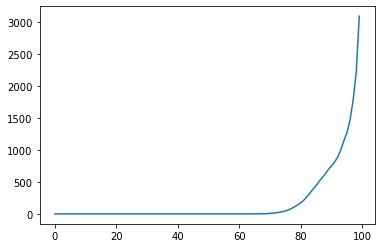

In [19]:
# See the quantiles of RoomService
plt.plot(list(range(100)),[np.quantile(df_train['RoomService'][pd.isnull(df_train['RoomService']) == False],i/100) for i in range(100)])

In [20]:
#impute RoomService
#Since more than 70% of the observations are 0 we pass 0 to missing values
df_train['RoomService'][pd.isnull(df_train['RoomService'])] = 0


C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/2170093508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['RoomService'][pd.isnull(df_train['RoomService'])] = 0


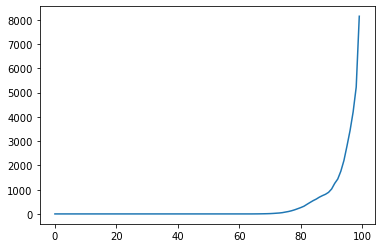

In [21]:
#See quantiles of FoodCourt
plt.plot(list(range(100)),[np.quantile(df_train['FoodCourt'][pd.isnull(df_train['FoodCourt']) == False],i/100) for i in range(100)])

In [22]:
df_train['FoodCourt'][pd.isnull(df_train['FoodCourt'])] = 0 #same as before

C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/3473107659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['FoodCourt'][pd.isnull(df_train['FoodCourt'])] = 0 #same as before


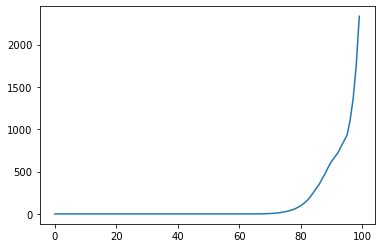

In [23]:
#See quantiles of ShoppingMall
plt.plot(list(range(100)),[np.quantile(df_train['ShoppingMall'][pd.isnull(df_train['ShoppingMall']) == False],i/100) for i in range(100)])

In [24]:
#Impute ShoppingMall
df_train['ShoppingMall'][pd.isnull(df_train['ShoppingMall'])] = 0 #same as before

C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/3682198473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ShoppingMall'][pd.isnull(df_train['ShoppingMall'])] = 0 #same as before


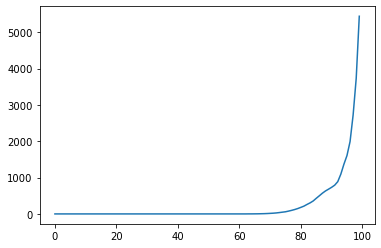

In [25]:
#See quantiles of Spa
plt.plot(list(range(100)),[np.quantile(df_train['Spa'][pd.isnull(df_train['Spa']) == False],i/100) for i in range(100)])

In [26]:
#Impute Spa
df_train['Spa'][pd.isnull(df_train['Spa'])] = 0 #same as before

C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/2782338475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Spa'][pd.isnull(df_train['Spa'])] = 0 #same as before


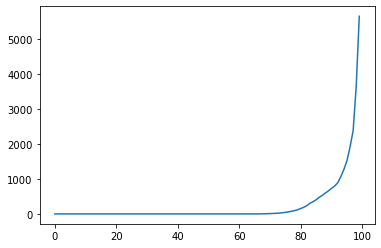

In [27]:
#See quantiles of VRDeck
plt.plot(list(range(100)),[np.quantile(df_train['VRDeck'][pd.isnull(df_train['VRDeck']) == False],i/100) for i in range(100)])

In [28]:
#Impute #Impute VRDeck
df_train['VRDeck'][pd.isnull(df_train['VRDeck'])] = 0 #same as before

C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/2211715094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['VRDeck'][pd.isnull(df_train['VRDeck'])] = 0 #same as before


In [29]:
print(df_train.isnull().sum()) #no missing values

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
deck            0
side            0
dtype: int64


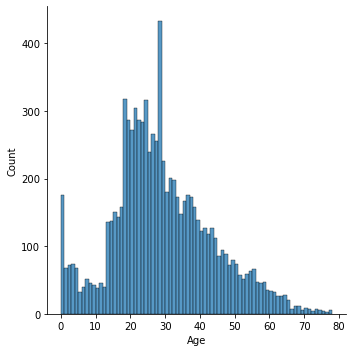

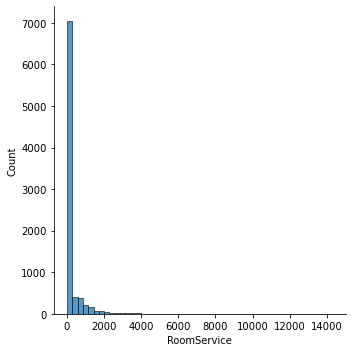

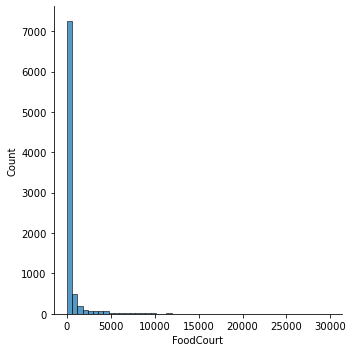

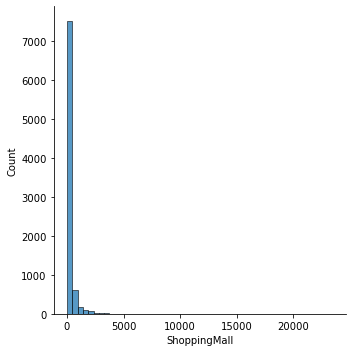

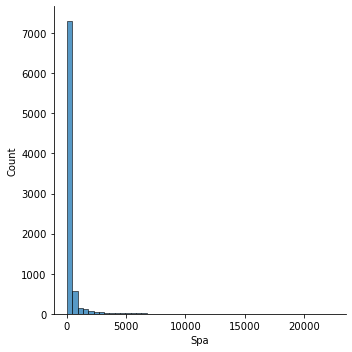

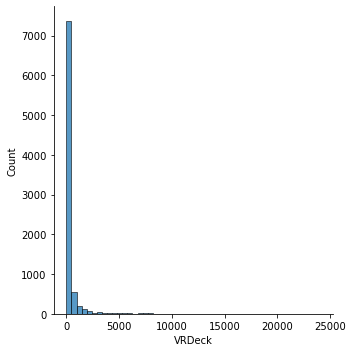

In [30]:
#EDA
#Univariate
#We will create a function which will return the categorical and contiuous variables of the dataset
#according to the levels we pass to the function. We have stated a default value equals to 10
#although with 10 levels a variable is categorical.
#The idea of the function is that each variable with more than the max_levels_for_categorical is concidered continuous otherwise categorical
def list_categorical_continuous(df,max_lvls_for_categorical = 10): # we also pass the dataframe
    columns = df.columns #we get the name of the columns
    categorical = [] #We initialize two empty lists
    continuous = []
    for i in columns:#we run a for in the names of the columns
        if len(df[i].unique()) > max_lvls_for_categorical: #if the number of levels is greater than the max_levels
            continuous.append(i) #we append the name in the list continuous
        else:#otherwise
            categorical.append(i) #in the list called categorical
    return [categorical, continuous] # and we return a list of lists
df = df_train.drop(columns = "PassengerId") #we drop the passenger id which is the primary key 
variables = list_categorical_continuous(df) #and we run the function
for i in variables[1]: #we get histograms for the continuous
    sns.displot(df_train[i], bins = list(range(int(np.min(df_train[i])), int(np.max(df_train[i])),int((np.max(df_train[i])-np.min(df_train[i]))/50))))
    

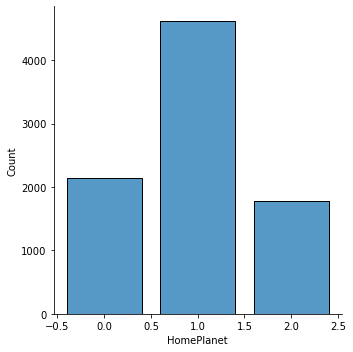

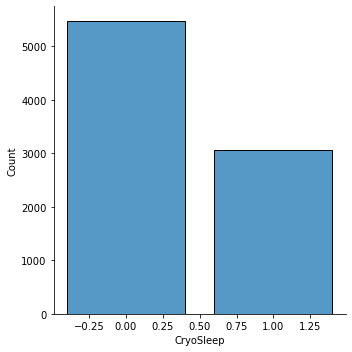

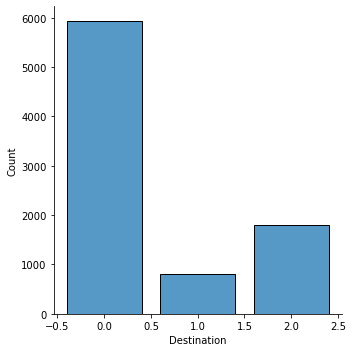

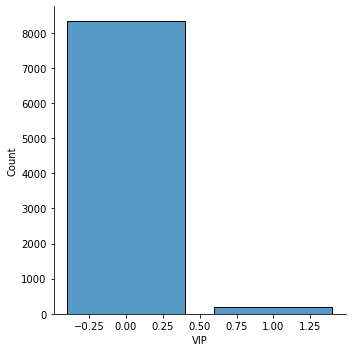

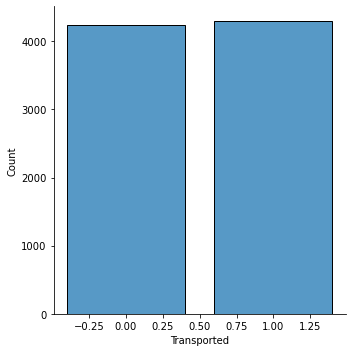

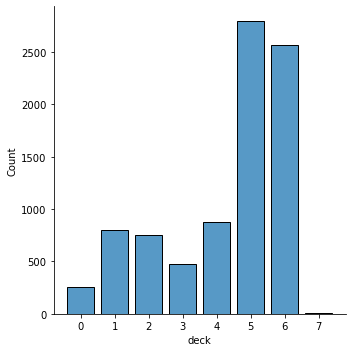

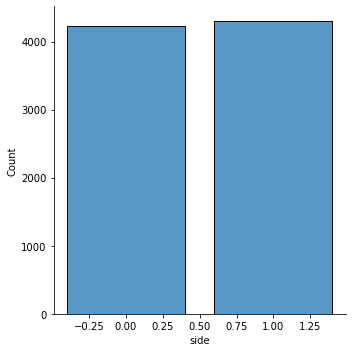

In [31]:
#Univariate Categoricals
for i in variables[0]: #and for the categoricals
    sns.displot(df_train[i], discrete = True, shrink = 0.8)

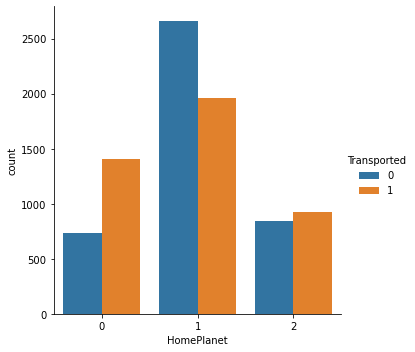

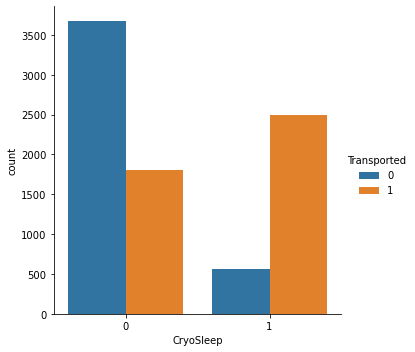

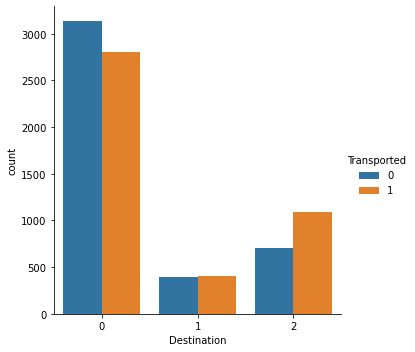

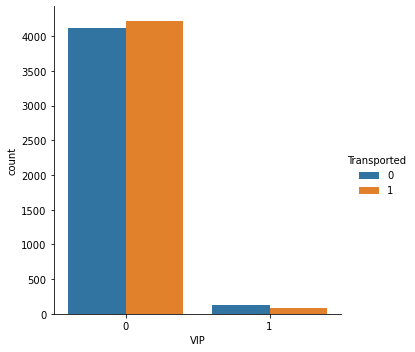

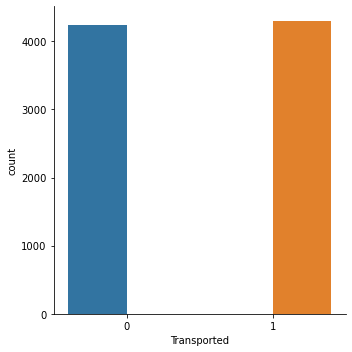

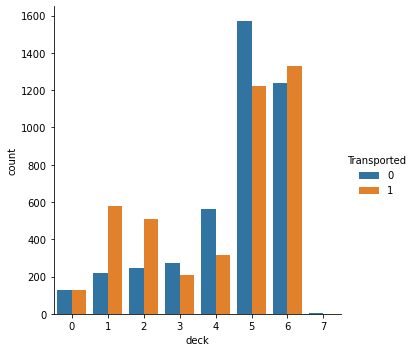

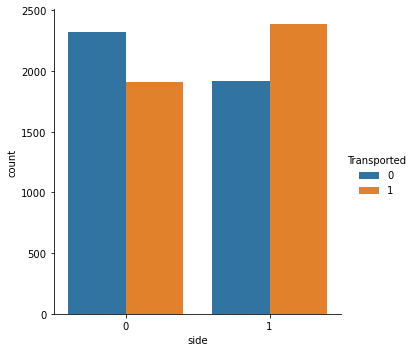

In [32]:
#Bivariate Analysis
for i in variables[0]: #we get barplots for each categorical variable split it by the Y variable
    sns.catplot(data = df_train, x = i, hue = 'Transported', kind = 'count')

In [33]:
#prepairing the array to fit on the model
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
#from sklearn.model_selection import get_n_splits
Y = df_train['Transported'].to_numpy().astype("int") #We prepare the dataset to build a model
X = df_train.drop(columns = ['Transported', 'PassengerId']).to_numpy().astype("int")


In [34]:
#Build the model
#Decision Trees with cross validation
dtc = DecisionTreeClassifier() 
scores = cross_val_score(dtc, X, Y, cv = 100)

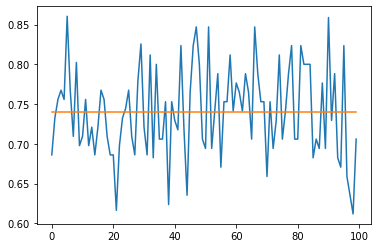

<AxesSubplot:>

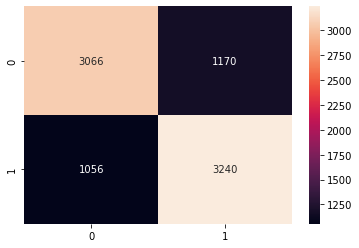

In [36]:
plt.plot(scores)
plt.plot(list(range(100)), [scores.mean()]*100)
plt.show()
cvDTC = cross_val_predict(dtc, X, Y, cv = 100)
sns.heatmap(confusion_matrix(Y, cvDTC), annot = True, fmt = '')

In [37]:
#Random Forest with cross validation
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth = 5, max_features = 3)
scoresRF = cross_val_score(rfc, X, Y, cv = 100)

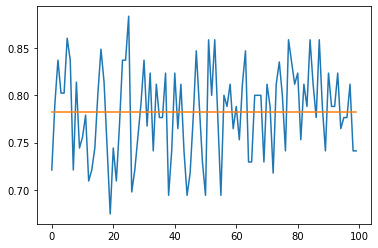

<AxesSubplot:>

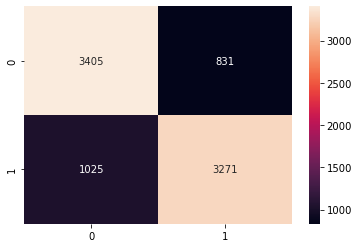

In [38]:
plt.plot(scoresRF)
plt.plot(list(range(100)), [scoresRF.mean()]*100)
plt.show()
cvRFC = cross_val_predict(rfc, X, Y, cv = 100)
sns.heatmap(confusion_matrix(Y, cvRFC), annot = True, fmt = '')

In [39]:
#SVM with cross validation
from sklearn import svm
SPVC = svm.SVC(kernel = 'poly')
scoresSVM = cross_val_score(SPVC, X, Y, cv = 100)

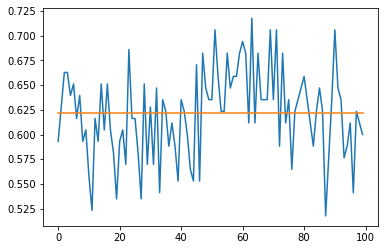

<AxesSubplot:>

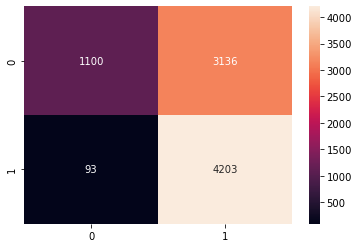

In [40]:
plt.plot(scoresSVM)
plt.plot(list(range(100)), [scoresSVM.mean()]*100)
plt.show()
cvSVM = cross_val_predict(SPVC, X, Y, cv = 100)
sns.heatmap(confusion_matrix(Y, cvSVM),annot = True, fmt = '')

In [41]:
#Multionamial Naive Bayse
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
scoresMNB = cross_val_score(MNB, X, Y, cv = 100)

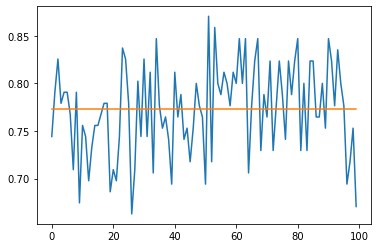

<AxesSubplot:>

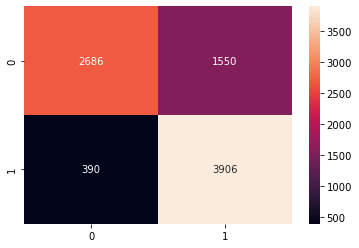

In [42]:
plt.plot(scoresMNB)
plt.plot(list(range(100)), [scoresMNB.mean()]*100)
plt.show()
cvMNB = cross_val_predict(MNB, X, Y, cv = 100)
sns.heatmap(confusion_matrix(Y, cvMNB),annot = True, fmt = '')

In [43]:
#despite the bad accuracy of SVM, we see that when it predicts 0, the accuracy is high.
cv1 = KFold(100) #We do 100-CV
prediction = []
for train, test in cv1.split(X): 
    final_model1 = SPVC.fit(X[train],Y[train])#we train the first model
    final_model2 = rfc.fit(X[train],Y[train])#We train the second model
    final_model3 = MNB.fit(X[train],Y[train])#We train the 3rd model
    final_model4 = dtc.fit(X[train],Y[train])#We train the 4th model
    pred_svm = final_model1.predict(X[test]) #we predict the validation set
    pred_rfc = final_model2.predict(X[test])
    pred_mnb = final_model3.predict(X[test])
    pred_dtc = final_model4.predict(X[test])
    for i in range(len(pred_svm)): 
        if pred_svm[i] == 0: #When svm predicts 0 
            prediction.append(0) #We append Zero
        else: #Otherwise
            pr = pred_rfc[i] + pred_mnb[i] + pred_dtc[i] #We vote
            pr = pr/3 #and divide by 3. The possible values for pr are 0, 1/3, 2/3, 1
            if pr >= 0.5: #If it is 2/3 or 1
                pr = 1 #2 out of 3 algorithms have predicted 1 and the prediction will be 1
            else: #Otherwise 0
                pr = 0
            prediction.append(pr)
    

<AxesSubplot:>

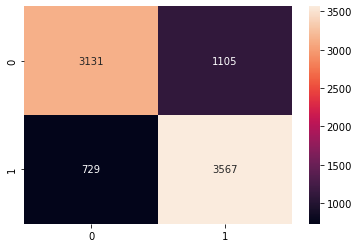

In [44]:
sns.heatmap(confusion_matrix(Y, prediction),annot = True, fmt = '')

In [45]:
df_test = pd.read_csv(path + path_test)#We pass the test set
del df_test['Name'] #We delete the Name as on the training set
test_set = df_test 
#test_set = df_test.loc[df_test.isnull().any(axis=1) == False]
#test_set = test_set.reset_index(drop = True)

In [46]:
test_set

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0


In [47]:
cabin1 = split_the_cabin(test_set['Cabin']) #Same proccess as in the training set
test_set['deck'] = cabin1[0] #We create a new variable deck and pass the deck list from the function above
#df_train['num'] = cabin1[1] #We create a new variable num and pass the num list from the function above
test_set['side'] = cabin1[2] #We create a new variable side and pass the num list from the function above
del test_set['Cabin'] #We delete the variable Cabin since we have replaced it with the 3 new variables above

In [48]:
count = 0 #we initialize a counter to take into account different variable each time the counter changes
for i in lista: #for i in the outer list
    count += 1 #We add 1 to the counter
    count1 = 0 #we initialize a second counter which describes the replacement of each level
    for j in i: #for j in the lists of the outer list
        if count == 1: #If the counter is 1(the first iteration) then i represents the list HD which is for the HomePlanet
            test_set['HomePlanet'][test_set['HomePlanet'] == j] = count1 #it will go through the same if number-of-levels times
        elif count == 2:#same for the second iteration of the outer for-loop
            test_set["Destination"][test_set["Destination"] == j] = count1 #we pass 0 for the first level, 1 for the second level, and 2 for the third level
        elif count == 3:#same as before
            test_set["deck"][test_set["deck"] == j] = count1
        elif count == 4:
            test_set["side"][test_set["side"] == j] = count1
        count1 += 1


test_set["CryoSleep"][test_set["CryoSleep"] == False] = 0 #we also replace false with zero 
test_set["VIP"][test_set["VIP"] == False] = 0
#test_set["Transported"][test_set["Transported"] == False] = 0
test_set["CryoSleep"][test_set["CryoSleep"] == True] = 1 #and true with 1
test_set["VIP"][test_set["VIP"] == True] = 1
#test_set["Transported"][test_set["Transported"] == True] = 1

C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/3903530741.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['HomePlanet'][test_set['HomePlanet'] == j] = count1 #it will go through the same if number-of-levels times
C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/3903530741.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["Destination"][test_set["Destination"] == j] = count1 #we pass 0 for the first level, 1 for the second level, and 2 for the third level
C:\Users\jimbi\AppData\Local\Temp/ipykernel_3264/3903530741.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [49]:
test_set = test_set.fillna(0) #In this case we pass 0 to all missing values

In [50]:
X_test = test_set.drop(columns = 'PassengerId').to_numpy().astype("int") #Create an array

In [51]:
pred_svm1 = final_model1.predict(X_test) #we predict the test set based on the based model found above which is to pass it through each model
pred_rfc1 = final_model2.predict(X_test)
pred_mnb1 = final_model3.predict(X_test)
pred_dtc1 = final_model4.predict(X_test)
prediction1 = []
for i in range(len(pred_svm1)):
    if pred_svm1[i] == 0:
        prediction1.append(0)
    else:
        pr = pred_rfc1[i] + pred_mnb1[i] + pred_dtc1[i]
        pr = pr/3
        if pr >= 0.5:
            pr = 1
        else:
            pr = 0
        prediction1.append(pr)

In [ ]:
import csv
count2 = 0 #We write the results into a CSV file
f = open(path + "/submition.csv", "w", newline = '')
writer = csv.writer(f,delimiter=",")
text = ['PassengerId', "Transported"]
writer.writerow(text)
for i in test_set['PassengerId']:
    if prediction1[count2] == 0:
        wrt = False
    else:
        wrt = True
    text = [i , wrt]
    writer.writerow(text)
    count2 += 1
f.close() 
#After Submitting it to Kaggle, the accuracy we got is 0.79284

In [ ]:
len(df_train)